In [1]:
from fwell.fwell import FWell
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cProfile, pstats

outer_bound = "nnnn"
top_bound = "imp"
bottom_bound = 'imp'
wtype = 'hor'
nseg = 20
nwells = 1
Xe = 1000
Ye = 1000
xw = Xe/2
yw = Ye/2
k = 10
h = 10
Lh = 500
rw = 0.1
xwds = [xw/(Lh/2)]
ywds = [yw/(Lh/2)]
xed = Xe/(Lh/2)
yed = Ye/(Lh/2)
hd = 2*h/Lh
rwd = rw/h
zwds = [0.5]
ct = 1e-5
mu = 1
B = 1
fi = 0.1
Q = 100
ts = np.logspace(-2,3, 100)
CT = 0.00036*k/(fi*mu*ct*(Lh/2)*(Lh/2))
CP = Q*18.42*mu*B/(k*h)
tds = ts*CT
fwell = FWell(outer_bound, top_bound, bottom_bound, wtype, nseg, nwells, xwds, ywds, xed=xed, yed=yed,
              zwds=zwds, hd=hd, rwd=rwd, attrs={'Fcd': 1e+6})

In [2]:
df = pd.read_csv('./saphire/hor_test_1.txt', delim_whitespace=True, skiprows = 11)
t_saph = np.array(df["(hr)"])
p_saph = np.array(df["(atm)"])
print(len(t_saph))

255


In [3]:
res = np.array([])
for t in t_saph:
    if t != 0:
        res = np.append(res, CP*fwell.pw(CT*t))

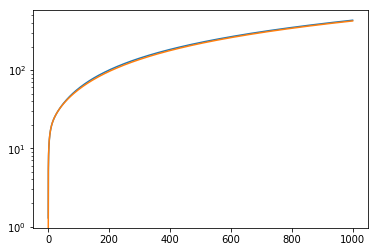

In [4]:
plt.yscale("log")
plt.plot(t_saph[1:], res)
plt.plot(t_saph, p_saph[0]-p_saph)

In [5]:
((p_saph[0]-p_saph[1:])-res)

array([ 5.13569418e-01,  5.19556378e-01,  5.25323126e-01,  5.31751938e-01,
        5.38355814e-01,  5.45013092e-01,  5.51612939e-01,  5.58065145e-01,
        5.64301655e-01,  5.70846441e-01,  5.77765523e-01,  5.84959677e-01,
        5.92299433e-01,  5.99634358e-01,  6.06784384e-01,  6.13538201e-01,
        6.19679261e-01,  6.24978637e-01,  6.29167311e-01,  6.32017880e-01,
        6.33364929e-01,  6.32750649e-01,  6.30159105e-01,  6.24403189e-01,
        6.17025472e-01,  6.06997428e-01,  5.98886424e-01,  5.82762068e-01,
        5.54020144e-01,  5.43252669e-01,  5.18346089e-01,  4.87347348e-01,
        4.59753080e-01,  4.28204813e-01,  3.94879517e-01,  3.60126540e-01,
        3.24442815e-01,  2.88382767e-01,  2.52533140e-01,  2.17482447e-01,
        1.83783739e-01,  1.51904542e-01,  1.22183546e-01,  9.51319879e-02,
        6.98867891e-02,  6.72681174e-02,  3.80386202e-02,  3.83077539e-02,
        1.80160378e-02, -9.27491926e-03,  2.70604010e-02,  4.34220645e-03,
        3.34980264e-03,  

In [5]:
from fwell.ffunc.ffuncs import *

In [6]:
def wtrans_v(vfunc, r, verbose=0):
    # returns VanWijngaarden - transformation terms w_r:
    # sum[v_r, r=1..oo] = sum[(-1)**(r-1)*w_r, r=1..oo]
    # vfunc - lambda-like function to eval with integer r
    # returns w_r
    MAXIT = 10000
    TINY = 1e-30
    EPS = 1e-12
    psum = vfunc(r)
    cpow = 2.
    for j in range(1,MAXIT):
        d = cpow*vfunc(cpow*r)
        psum += d
        cpow *= 2.
        ad = np.max(np.abs(d))
        if ad < (np.min(np.abs(psum))+TINY)*EPS or ad < TINY:
            if verbose==0:
                return psum
            elif verbose == 1:
                return psum, j
            elif verbose >= 2:
                return psum, j, d
    raise RuntimeError("{}".format(r))
    
def eulsum_v_(psum, term, jterm, wksp, nterm):
    if jterm == 1:
        nterm = 1
        wksp[1] = term.copy()
        psum = 0.5*wksp[1]
    else:
        tmp = wksp[1].copy()
        wksp[1] = term.copy()
        for j in range(1, nterm):
            dum = wksp[j+1].copy()
            wksp[j+1] = 0.5*(wksp[j]+tmp)
            tmp=dum.copy()
            wksp[nterm+1] = 0.5*(wksp[nterm]+tmp)
            tmp=dum.copy()
        wksp[nterm+1] = 0.5*(wksp[nterm]+tmp)
        if np.max(np.abs(wksp[nterm+1])) <= np.max(np.abs(wksp[nterm])):
            nterm += 1
            psum += (0.5*wksp[nterm])
        else:
            psum += wksp[nterm+1]
    return psum, wksp, nterm

def eulsum_v(vfunc, vfunc_shape, j_0=False):
    # euler's algo for series summation 
    # vfunc - scalar-valued lambda-like function function
    # param: j_0 - whether to account for 0-th term in sum
    MAXTERM = 1000
    EPS = 1e-9
    TINY = 1e-20
    wksp = np.zeros((MAXTERM, *vfunc_shape), dtype=np.float)
    nterm = 0
    sign = 1.
    ppsum = np.zeros(vfunc_shape)
    # account for 0-th term
    if j_0:
        psum = vfunc(0)
    else:
        psum = np.zeros(vfunc_shape)
    for j in range(1, MAXTERM):
        term = sign*wtrans_v(vfunc, j, verbose=0) 
        sign *= -1.
        psum, wksp, nterm = eulsum_v_(psum, term, j, wksp, nterm) 
        apsum = np.min(np.abs(psum))+0.5*TINY
        if np.max(np.abs(psum-ppsum)) < EPS*apsum or apsum < TINY:
            return psum
        ppsum = psum.copy()
    raise RuntimeWarning("In eulsum: series did not converge in {} iterations".format(MAXTERM))

In [7]:
from fwell.ffunc.ffuncs import F2H1k, F2H1
# (k, b, u, ksid, ksiwd, ksied, ksiede, a, yd, ywd)

In [8]:
zd, zwd, yd, ywd, hd, xd, xwd = fwell.lw.zd, fwell.lw.zwd, fwell.lw.yd, fwell.lw.ywd, fwell.lw.hd, fwell.lw.xd, fwell.lw.xwd
x1, x2 = fwell.lw.x1, fwell.lw.x2
b = 1
u = 1e-4
ksid = xd
ksiwd = xwd
ksied = xed
ksiede = xed
vfunc = lambda k: F2H1k(k,b,u,ksid,ksiwd,ksied,ksiede,0,yd,ywd)

In [ ]:
term = wtrans_v(vfunc,1, verbose=0)
jterm = 1
psum = np.zeros_like(xd)
wksp = np.zeros((10, *(psum.shape)))
nterm=0
eulsum_v_(psum, term, jterm, wksp, nterm)

In [18]:
from scipy.special import k0
from fwell.ffunc.aux import eulsum
u = 0.00814443458076589
def F2H1_new(u, ksid, ksiwd, ksied, ksiede, a, yd, ywd):
    val = np.zeros_like(ksid)
    for sx in [-1,1]:
        val += k0(np.sqrt((u+a*a)*(np.square(ksiede/ksied*(ksid+sx*ksiwd))+np.square(yd-ywd))))
    for sx in [-1,1]:
        for sk in [-1,1]:
            vfunc = lambda k: k0(np.sqrt((u+a*a)*(np.square(ksiede/ksied*(ksid+sx*ksiwd+sk*2*k*ksied))+np.square(yd-ywd))))
            val += eulsum_v(vfunc, xd.shape)
    return val

In [20]:
%timeit -n10 -r1 F2H1_new(0.00814443458076589, zd, zwd, 1, hd, 0, yd, ywd)

193 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [22]:
%timeit -n10 -r1 F2H1(1, zd, zwd, 1, hd, 0, yd, ywd)
%timeit -n10 -r1 F2H1_new(1, zd, zwd, 1, hd, 0, yd, ywd)

209 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
118 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [23]:
np.allclose(F2H1(1, zd, zwd, 1, hd, 0, yd, ywd), F2H1_new(1, zd, zwd, 1, hd, 0, yd, ywd), rtol=1e-4)

True

In [64]:
np.allclose(val,F2H1(u, ksid, ksiwd, ksied, ksiede, 0, yd, ywd),rtol=1e-4)

True

In [39]:
F2H1(u, ksid, ksiwd, ksied, ksiede, 0, yd, ywd)

array([[78.21326993, 78.21326993, 78.21326993, ..., 78.21326993,
        78.21326993, 78.21326993],
       [78.25576223, 78.25576223, 78.25576223, ..., 78.25576223,
        78.25576223, 78.25576223],
       [78.30175387, 78.30175387, 78.30175387, ..., 78.30175387,
        78.30175387, 78.30175387],
       ...,
       [78.30175387, 78.30175387, 78.30175387, ..., 78.30175387,
        78.30175387, 78.30175387],
       [78.25576223, 78.25576223, 78.25576223, ..., 78.25576223,
        78.25576223, 78.25576223],
       [78.21326993, 78.21326993, 78.21326993, ..., 78.21326993,
        78.21326993, 78.21326993]])

In [10]:
F2H1(0.00814443458076589, zd, zwd, 1, hd, 0, yd, ywd)


RuntimeError: F2H1 did not converge for u = 0.00814443458076589

In [17]:
def IF3(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid1, fid2):
    if3 = IF31(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid1) +\
            IF32(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid2)
    return if3

def IF31(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    return ihF2E(zd, zwd, x1, x2, u, xd, xwd, xed, xed, hd, yd, ywd, yed, buf, fid)

def IF32(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    if32 = IF321(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid+"_1") +\
        IF322(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid+"_2")
    return if32

def IF321(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    MAXITER = 1000
    EPS = 1e-6
    coef = 0.5*xed/np.pi
    sum1, sum2, m = np.zeros_like(x1), np.zeros_like(x1), np.zeros_like(x1)
    for n in range(1, MAXITER):
        v1, v2, vm = IF321_n(n, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
        sum1 += v1
        sum2 += v2
        m += vm
        if np.linalg.norm(v1) < EPS*np.linalg.norm(sum1) and np.linalg.norm(v2) < EPS*np.linalg.norm(sum2):
            break
    ans = sum1 + sum2
    ans += IF321_aux_(u, zd, zwd, hd)*np.abs(0.5*m)
    return ans

def IF321_aux(u,zd, zwd, hd):
    MAXITER = 100000
    EPS = 1e-9
    sum_ = k0(np.sqrt(u*np.square((zd + zwd)*hd)))
    sum_ += k0(np.sqrt(u*np.square((zd - zwd)*hd)))
    for n in range(1, MAXITER):
        d = k0(np.sqrt(u*np.square((zd - zwd - 2*n)*hd))) + k0(np.sqrt(u*np.square((zd + zwd - 2*n)*hd)))
        d += k0(np.sqrt(u*np.square((zd - zwd + 2*n)*hd))) + k0(np.sqrt(u*np.square((zd + zwd + 2*n)*hd)))
        sum_ += d
        if np.linalg.norm(d) < EPS*np.linalg.norm(sum_):
            return 0.5*hd*sum_ - 0.5*np.pi/np.sqrt(u), sum_
    raise RuntimeWarning("IF321_aux did not converge")
    
def IF321_aux_(u,zd_, zwd_, hd):
    mshape = zd_.shape
    assert zwd_.shape == mshape
    zd = zd_[0,0]
    zwd = zwd_[0,0]
    sum_ = k0(np.sqrt(u*np.square((zd + zwd)*hd)))
    sum_ += k0(np.sqrt(u*np.square((zd - zwd)*hd)))
    for sz in [-1,1]:
        for sn in [-1,1]:
            vfunc = lambda n: k0(np.sqrt(u*np.square((zd + sz*zwd + sn*2*n)*hd)))
            sum_ += eulsum(vfunc)
    sum_ *= np.ones_like(zd_)
    return 0.5*hd*sum_ - 0.5*np.pi/np.sqrt(u)
        
def IF321_n(n, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    MAXITER = 1000
    EPS = 1e-6
    PI = np.pi
    mult = np.cos(n*PI*zd)*np.cos(n*PI*zwd)
    sum1, sum2, m = np.zeros_like(x1), np.zeros_like(x1), np.zeros_like(x1)
    for b in [-1, 1]:
        v1, v2, vm = IF321_nk(0, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
        sum1 += v1
        sum2 += v2
        m += vm
    for k_ in range(1, MAXITER):
        for k in [-k_, k_]:
            for b in [-1, 1]:
                v1, v2, vm = IF321_nk(k, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid)
                sum1 += v1
                sum2 += v2
                m += vm
                if np.linalg.norm(v1) < EPS*np.linalg.norm(sum1) and np.linalg.norm(v2) < EPS*np.linalg.norm(sum2):
                    return mult*sum1, mult*sum2, m
    raise RuntimeError
    
def IF321_nk(k, n, b, u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed, buf, fid):
    # prep
    NDIGITS = 6
    mshape = x1.shape
    v_1 = np.zeros(mshape, dtype=np.double)
    v_2 = np.zeros(mshape, dtype=np.double)
    m1 = np.zeros(mshape, dtype=np.double)
    m2 = np.zeros(mshape, dtype=np.double)
    # calc
    dyd = yd - ywd
    inds_0 = np.isclose(dyd,0)
    inds_nnz = np.logical_not(inds_0)
    su = np.sqrt(u + np.square(n*np.pi/hd))
    if np.any(inds_0):
        t1 = xd[inds_0] + b*xwd[inds_0] - 2*k*xed - x2[inds_0]
        t2 = xd[inds_0] + b*xwd[inds_0] - 2*k*xed - x1[inds_0]
        mask1 = -1*(np.ones_like(t1) - 2*(t1>0))
        mask2 = -1*(np.ones_like(t1) - 2*(t2<0))
        t1 = np.round(np.abs(t1), decimals=NDIGITS).flatten()
        t2 = np.round(np.abs(t2), decimals=NDIGITS).flatten()
        nt = len(t1)
        t = np.append(t1,t2)
        ut, inv_t = np.unique(t, return_inverse=True)
        uv = ki1(ut*su)/su
        v = uv[inv_t]
        v1 = v[:nt]
        v2 = v[nt:]
        v_1[inds_0] = v1
        m1[inds_0] = mask1
        v_2[inds_0] = v2
        m2[inds_0] = mask2
    if np.any(inds_nnz):
        raise NotImplementedError
    return m1*v_1, m2*v_2, m1+m2  

def IF322(u, x1, x2, zd_, zwd_, hd, xd, xwd, xed, yd_, ywd_, yed, buf, fid):
    zd, zwd, yd, ywd = zd_[0,0], zwd_[0,0], yd_[0,0], ywd_[0,0]
    dyd = np.abs(yd-ywd)
    psum = k0(np.sqrt(u*(np.square((zd+zwd)*hd) + np.square(dyd)))) + k0(np.sqrt(u*(np.square((zd-zwd)*hd) + np.square(dyd))))
    for sz in [-1,1]:
        for sn in [-1,1]:
            func = lambda n: k0(np.sqrt(u*(np.square((zd+sz*zwd-2*sn*n)*hd) + np.square(dyd))))
            psum += eulsum(func)
    return 0.5*(x2-x1)*(0.5*hd*np.pi*psum - 0.5*np.exp(-np.sqrt(u)*dyd)/np.sqrt(u))
                        
    

255


In [20]:
u = 1e-3
v = IF3(u, x1, x2, zd, zwd, hd, xd, xwd, xed, yd, ywd, yed,fwell.lw.buf, "", "")

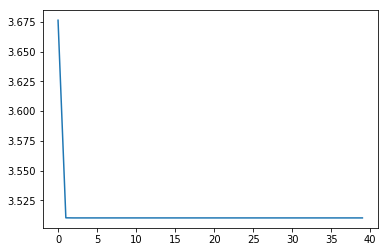

In [21]:
plt.plot(v[0,:])